# Compare and interpret the models

In the previous step we trained a model to identify legitimate and fraudulent transactions. There were a few different algorithms that we could choose from and in this notebook we will compare the performance metrics from each of the model options. We will also examine how each of the models use the input features to make predicitons.

In [1]:
import pandas as pd
import numpy as np
import shap
df = pd.read_parquet("fraud-cleaned-sample.parquet")

Load the dataset used to train each of the models

In [2]:
first = df['timestamp'].min()
last = df['timestamp'].max()
cutoff = first + ((last - first) * 0.7)

train = df[df['timestamp'] <= cutoff].copy()
test = df[df['timestamp'] > cutoff]

In [3]:
import cloudpickle as cp
feature_pipeline = cp.load(open('feature_pipeline.sav', 'rb'))
svecs = feature_pipeline.fit_transform(train)

Load each of the models

In [4]:
import pathlib

models = {}

if pathlib.Path('lr.sav').exists():
    models['lr'] = cp.load(open('lr.sav', 'rb'))
    
if pathlib.Path('rfc.sav').exists():
    models['rfc'] = cp.load(open('rfc.sav', 'rb'))
    
if pathlib.Path('xgb.sav').exists():
    models['xgb'] = cp.load(open('xgb.sav', 'rb'))

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


#### Model Performance Metrics

Let's first do a side-by-side comparison of the model performance metrics

In [5]:
from altair.expr import datum
import altair as alt

def pivot_class_report(df):
    
    df = df.T.unstack().reset_index(level=1, name='value')
    df = df.rename(columns={'level_1':'metric'})
    df = df.reset_index().rename(columns={'index': 'class'})
    return df

# Build a single dataset from each of the model performance metrics
df = pd.DataFrame(columns=['class', 'metric', 'value', 'model'])

for model in models:
    model_df = models[model]['class_report'][:2]
    model_df = pivot_class_report(model_df)
    model_df['model'] = model
    df = df.append(model_df)

# Remove the support column
df = df[df['metric'] != 'support']

# Chart the side-by-side metrics for each model
base = alt.Chart(df).mark_bar().encode(
    column='class',
    x='metric',
    y='value',
    color=alt.Color('model', scale=alt.Scale(range=['#EA98D2', '#659CCA', '#99e6ff']))
)

chart = alt.hconcat()

for model in ['lr', 'rfc', 'xgb']:
    chart |= base.transform_filter(datum.model == model)

chart.display()

alt.HConcatChart(...)

#### Interpret the Models

Model interpretability is an effort to examine and understand how the model arrives at its outcomes. The goal in interpreting a model is to understand the impact of the model features on the model outcome.

Some models, like logistic regression, are naturally more interpretable and straightforward than others. But as we add features and use more complicated algorithms, interpretability becomes more difficult. 

We will use a package called `shap` to interpret each of the models. This package uses a concept called 'Shapley value' and was derived from cooperative game theory by Lloyd Shapley in 1953. For each model, we will be able to see the average marginal contributions of each feature to the model outcomes.

In [6]:
import shap
import matplotlib.pyplot as plt

svecs_array = svecs.toarray()
svecs_df = pd.DataFrame.sparse.from_spmatrix(svecs)

#### Linear Regression Model

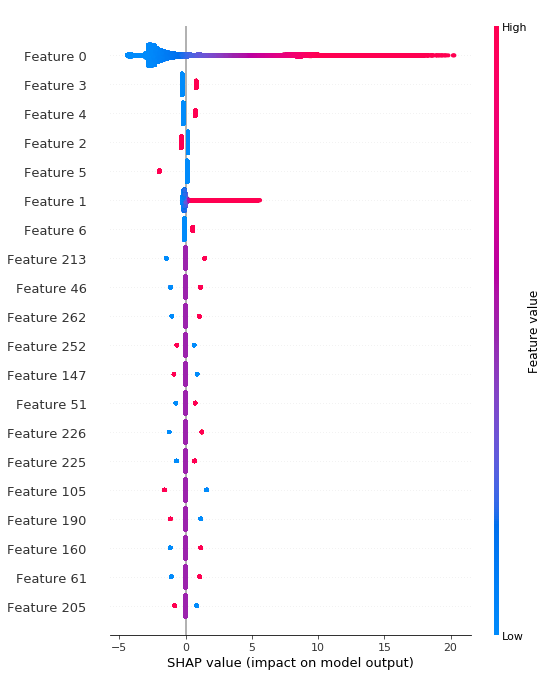

In [7]:
if 'lr' in models:
    lr_explainer = shap.LinearExplainer(models['lr']['model'], svecs, feature_perturbation="interventional")
    lr_shap_values = lr_explainer.shap_values(svecs)
    
    shap.summary_plot(lr_shap_values, svecs_array, show=False)
    plt.tight_layout()
    plt.show()
else:
    print("Linear Regression model not present")

#### Random Forest Model

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


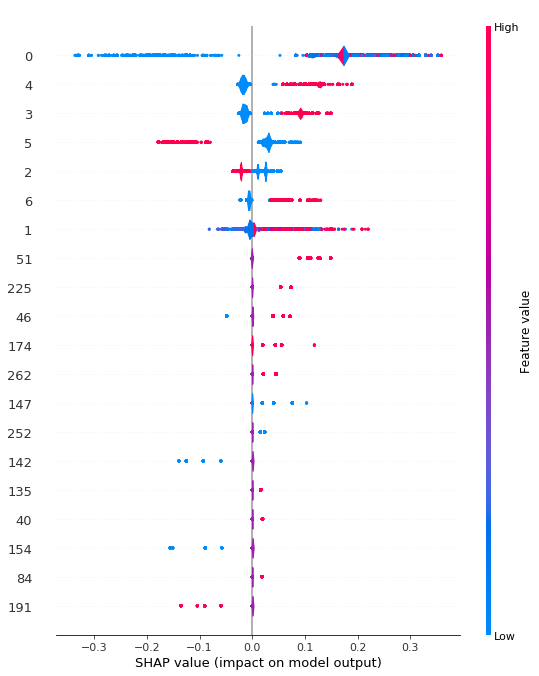

In [8]:
if 'rfc' in models:
    rfc_explainer = shap.TreeExplainer(models['rfc']['model'])
    rfc_shap_values = rfc_explainer.shap_values(svecs_df, approximate=True)
    
    shap.summary_plot(rfc_shap_values[1], svecs_df, plot_type="violin", show=False)
    plt.tight_layout()
    plt.show()
else:
    print("Random Forest model not present")

#### XGBoost Model

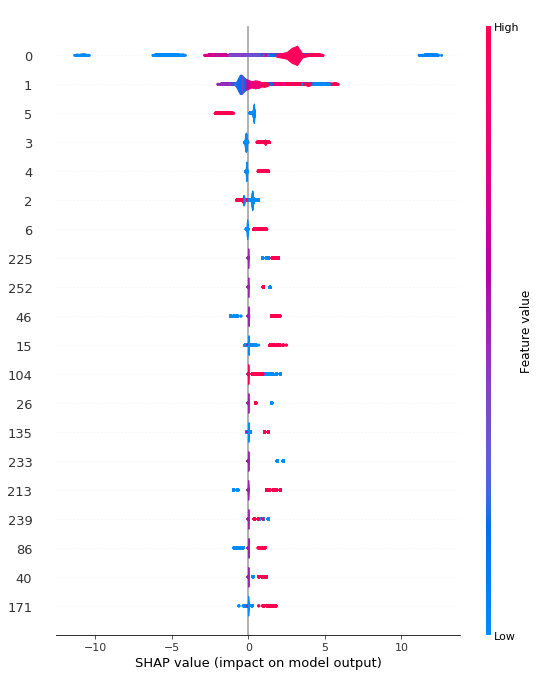

In [9]:
if 'rfc' in models:
    xgb_explainer = shap.TreeExplainer(models['xgb']['model'])
    xgb_shap_values = xgb_explainer.shap_values(svecs, approximate=True)
    
    shap.summary_plot(xgb_shap_values, svecs_df, plot_type="violin", show=False)
    plt.tight_layout()
    plt.show()
else:
    print("XGBoost model not present")